# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

* `dota_players.xlsx` - количество игроков, посетивших Dota 2. В источнике (SteamDB) не указано, какое значение за период было взято в качестве результата. Будем считать, что число обозначает максимальное количество за период.
* `dota_rating.xlsx` :
    * `Positive reviews`: количество положительных отзывов
    * `Negative reviews`: количество негативных отзывов
    * `Rating`: количество положительных и отрицательных отзывов. [Методика расчёта.](https://steamdb.info/blog/steamdb-rating/)

Предположим, что наша задача чисто техническая. Мы - маленькая инди-компания (sarcasm) Valve и хотим оптимизировать количество серверов, занимаемых для размещения игроков. Для этого нам необходимо прогнозировать посещаемость игры. На семинаре мы разбирали общий алгоритм прогнозирования рядов и сейчас мы попробуем выполнить все его шаги.

## Загрузка данных (0.5 балла)

1. Загрузите оба файла с данными. Преобразуйте время к формату `pd.Timestamp`.
2. У показателя `Количество игроков` менялась методика подсчёта. Вместо дневной статистики с определённого момента начала собираться почасовая. Чтобы не усложнять задачу, сконвертируем все данные в дневной формат. Ресэмплируйте данные к дневной частоте, используйте максимум как агрегирующую функцию.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (12,6)

In [ ]:
df_players = pd.read_excel('https://github.com/Pyatachokk/hse_ts_course/raw/refs/heads/master/2025-spring/homeworks/hw2/dota_players.xlsx')
df_rating = pd.read_excel('https://github.com/Pyatachokk/hse_ts_course/raw/refs/heads/master/2025-spring/homeworks/hw2/dota_rating.xlsx')

df_players.DateTime = pd.to_datetime(df_players.DateTime)
df_rating = df_rating.loc[1:].rename(columns = {'Chart': 'DateTime', 'Unnamed: 1': 'Positive_reviews', 'Unnamed: 2': 'Negative_reviews', 'Unnamed: 3': 'Rating'})
df_rating.DateTime = pd.to_datetime(df_rating.DateTime)

df_players.set_index('DateTime', inplace = True)
df_rating.set_index('DateTime', inplace = True)
df_players = df_players.resample(pd.offsets.Day()).max()

In [ ]:
pd.infer_freq(df_players.index)

'D'

## Внешние переменные (Бонус, 1 балл)

Внешние переменные, которые приведены в файле `dota_rating.xlsx`, не проходят тест Гранжера. Например, количество отзывов явно зависит от того, сколько людей поиграли в игру. С другой стороны, прочитавшие положительные или отрицательные отзывы люди могут принять решение о том, чтобы начать играть. В общем, зависимость явно может быть в обе стороны. С рейтингом логика схожая. Это не значит, что нельзя использовать переменные для прогнозирования, потому что Гранжер тестирует только линейную зависимость, но тем не менее переменные не самые лучшие.

1) Придумайте и найдите дополнительную переменную. (0.5 балла)
2) Переменная из п.1 числовая и проходит тест Гранжера. (0.5 балла)

In [150]:
# оаоао опять не хватило времени

## Препроцессинг (1 балл)

1) Заполните пропуски в данных. Обоснуйте выбранный вам метод. (0.75 балла)
2) Разбейте данные на трейн и тест. Длина теста: 14 дней. Далее будем работать только с трейном. (0.25 балла)



In [ ]:
df_players.isna().sum()

,0
Players,0


In [ ]:
df_rating.isna().sum()

,0
Positive_reviews,310
Negative_reviews,283
Rating,0


Посмотрим на распределение пропусков df_rating

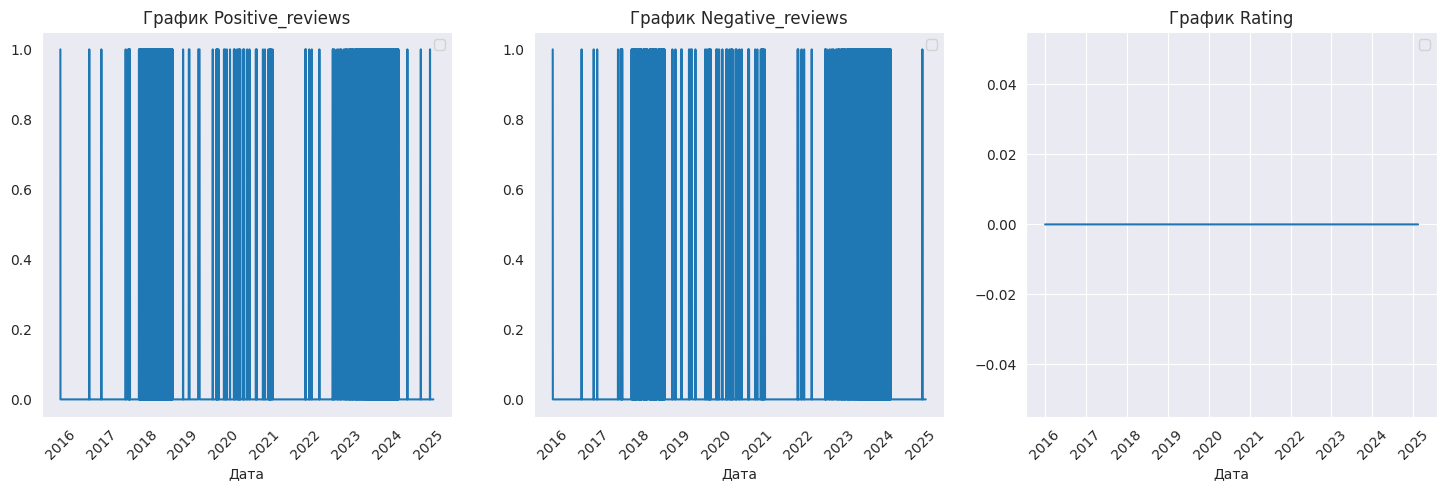

In [ ]:
nulls = df_rating.isnull() == 1
splits = 3
rows = nulls.shape[1]//splits + nulls.shape[1]%splits
fig, ax = plt.subplots(rows, splits, figsize = (18, 5))
ax = ax.flatten()
for i in range(nulls.shape[1]):
  plt.grid()
  ax[i].plot(nulls.index, nulls.iloc[:,i])
  ax[i].set_title(f'График {nulls.columns[i]}')
  ax[i].set_xlabel('Дата')
  # ax[i].set_ylabel('Количество');
  ax[i].legend();
  ax[i].grid();
  ax[i].tick_params(axis='x', rotation=45);

Видим, что у признаков про рейтинги достаточно много пропусков, особенно в период 2023-2024 год, посмотрим, на график автокорреляционной функции, чтобы выбрать наиболее подходящий способ заполнения пропусков.

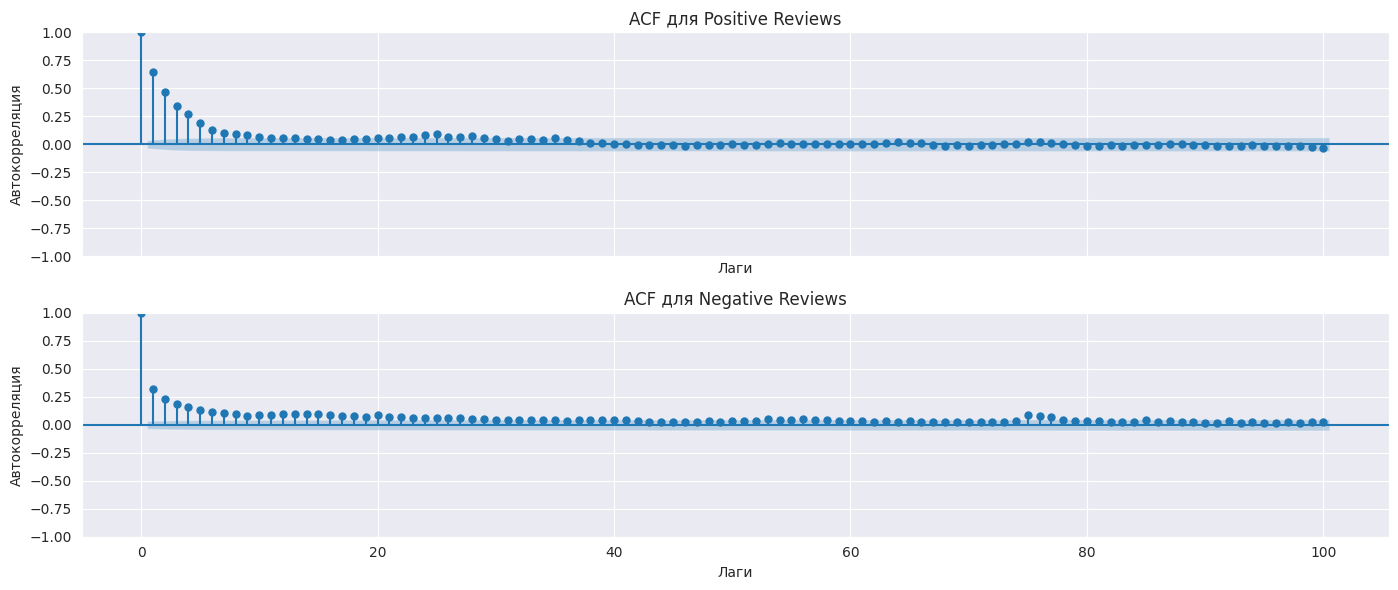

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_rating['Positive_reviews'].dropna(), ax=ax[0], lags = 100)
ax[0].set_title('ACF для Positive Reviews')
ax[0].set_xlabel('Лаги')
ax[0].set_ylabel('Автокорреляция')
ax[0].grid(True)

plot_acf(df_rating['Negative_reviews'].dropna(), ax=ax[1], lags = 100)
ax[1].set_title('ACF для Negative Reviews')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('Автокорреляция')
ax[1].grid(True)

plt.tight_layout()

Acf достаточно быстро убывает как для позитивных, так и для негативных отзывов в пределах (5-10 лагов) - долгосрочной зависимости между наблюдениями нет, повторяющихся пиков нет - можно сказать, что сезонности не наблюдается, если первые разности брать, то еще лучше будет видно. Оба ряда похожи на стационарные, значения достаточно быстро попадают внутрь границ доверительного интервала. Сделаем тест Дики Фуллера, проверим на стационарность.

In [ ]:
from statsmodels.tsa.stattools import adfuller


def check_stationarity(series, name):
    adf_test = adfuller(series.dropna())
    p_value = adf_test[1]

    print(f"ADF тест для {name}: p-value = {p_value:.2f}")
    if p_value < 0.05:
        print(f"Ряд {name} **стационарный** (p-value < 0.05)\n")
    else:
        print(f"Ряд {name} **нестационарный** (p-value > 0.05)\n")

check_stationarity(df_rating['Positive_reviews'], name="Positive Reviews")
check_stationarity(df_rating['Negative_reviews'], name="Negative Reviews")

ADF тест для Positive Reviews: p-value = 0.00
Ряд Positive Reviews **стационарный** (p-value < 0.05)

ADF тест для Negative Reviews: p-value = 0.00
Ряд Negative Reviews **стационарный** (p-value < 0.05)



Так как оба ряда стационарны, то можем заполнить пропуски просто средним значением, дисперсия и мат ожидание на меняются во времени, поэтому этот вариант подходит.

In [ ]:
df_rating.Positive_reviews = df_rating.Positive_reviews.fillna(df_rating.Positive_reviews.mean())
df_rating.Negative_reviews = df_rating.Negative_reviews.fillna(df_rating.Negative_reviews.mean())

Делаем сплит на две выборки, в тесте последние 14 дней.

In [ ]:
X_train, X_test = df_rating.iloc[:-14], df_rating.iloc[-14:]
y_train, y_test = df_players.iloc[:-14], df_players.iloc[-14:]

## Визуальный анализ (1 балл)

Изобразите временной ряд целиком и последние три месяца. Изобразите автокорреляции временного ряда (возьмите первые разности, так как ряд трендированный). Опишите, какие паттерны наблюдаются.



In [ ]:
# splits = 3
# rows = df_rating.shape[1]//splits + df_rating.shape[1]%splits
# fig, ax = plt.subplots(rows, splits, figsize = (20, 5))
# ax = ax.flatten()
# for i in range(df_rating.shape[1]):
#   plt.grid()
#   ax[i].plot(df_rating.index, df_rating.iloc[:,i])
#   ax[i].set_title(f'График {df_rating.columns[i]}')
#   ax[i].set_xlabel('Дата')
#   ax[i].set_ylabel('Количество');
#   ax[i].legend();
#   ax[i].grid(True);
#   ax[i].tick_params(axis='x', rotation=45);

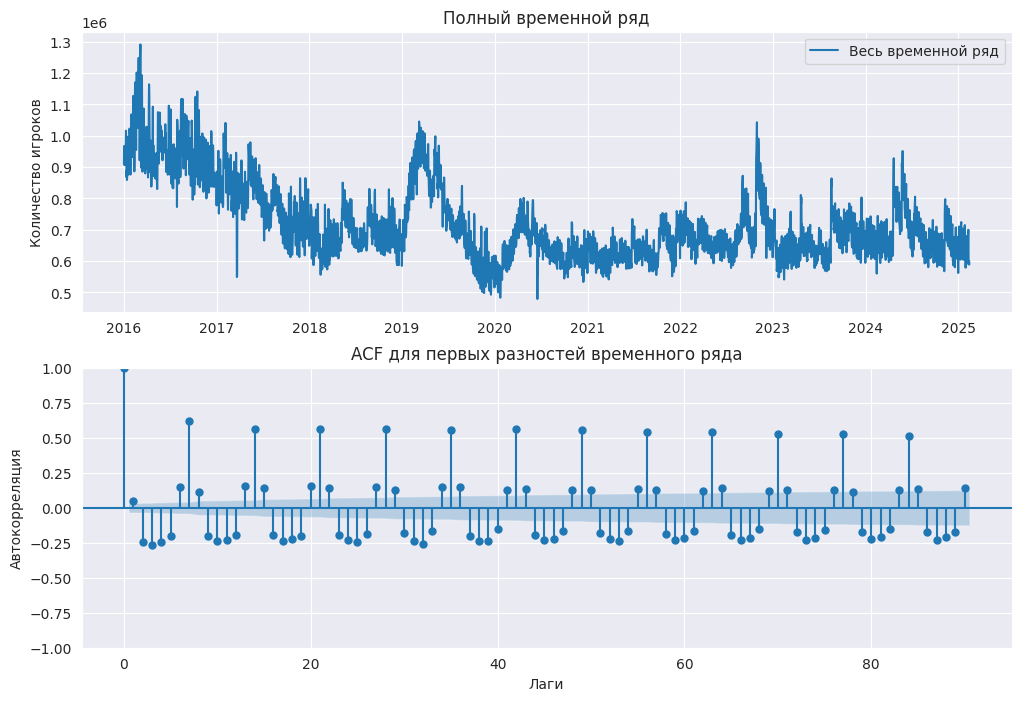

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(df_players.index, df_players['Players'], label='Весь временной ряд')
ax[0].set_title('Полный временной ряд')
ax[0].set_ylabel('Количество игроков')
ax[0].legend()
ax[0].grid(True)

plot_acf(df_players.diff().dropna(), ax=ax[1], lags = 90)
ax[1].set_title('ACF для первых разностей временного ряда')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('Автокорреляция')
ax[1].grid(True)

Видна значимая недельная сезонность, 4 дня рабочих - народ играет меньше, 3 дня (пт-вс) все бегут играть в доту.

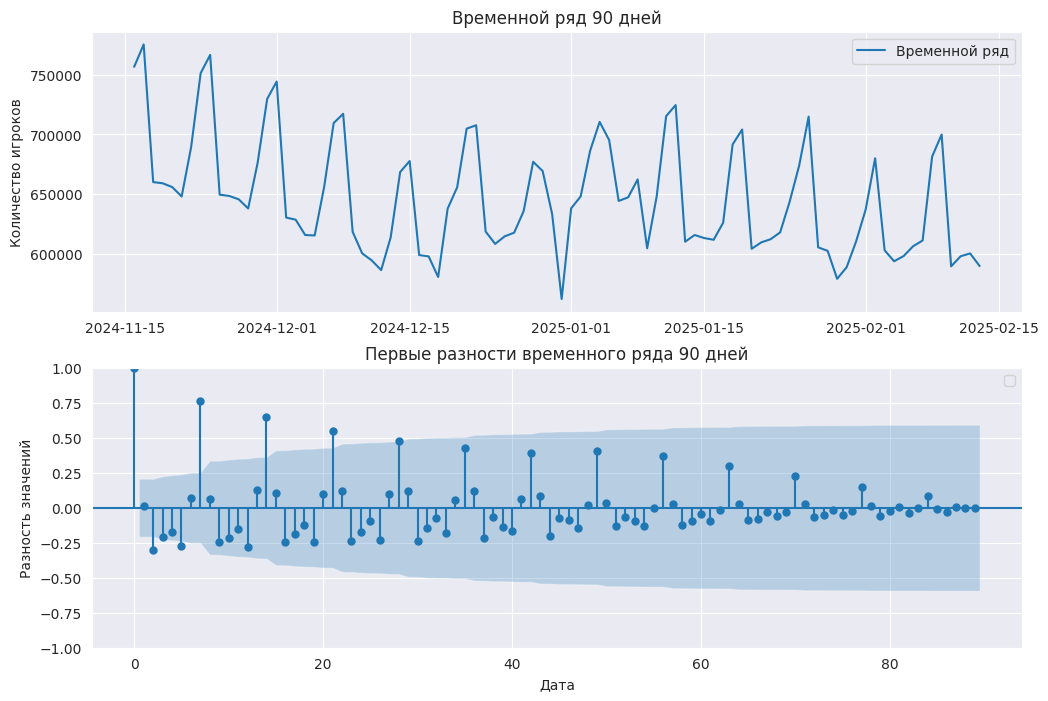

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(df_players.index[-90:], df_players['Players'][-90:], label='Временной ряд')
ax[0].set_title('Временной ряд 90 дней')
ax[0].set_ylabel('Количество игроков')
ax[0].legend()
ax[0].grid(True)

plot_acf(df_players.diff().dropna()[-90:], ax=ax[1], lags = 89)
ax[1].set_title('Первые разности временного ряда 90 дней')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Разность значений')
ax[1].legend()
ax[1].grid(True)

Так же видим сезонность на последних 90 наблюдениях, но достаточно быстро скатываемся в незначимую зону. Возможно после взятия первых разностей сезонность именно свежих наблюдений стала менее выраженной. Или наблюдается тренд на уменьшение кол-ва пользователей игры, поэтому зависимость между днями будет менее точная. Посмотрим ниже на тип сезонности - аддитивная или мультипликативная.

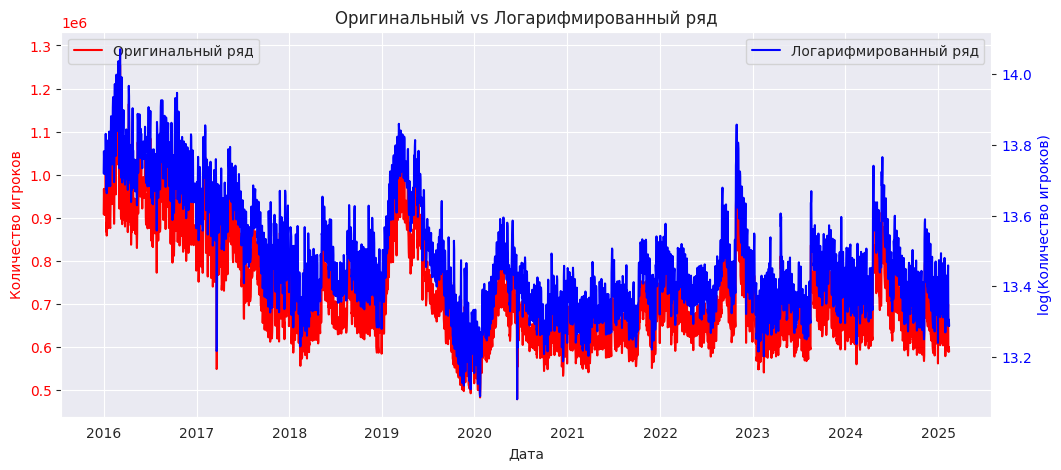

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df_players.index, df_players['Players'], color='red', label='Оригинальный ряд')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество игроков', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('Оригинальный vs Логарифмированный ряд')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_players.index, np.log(df_players['Players']), color = 'blue',label='Логарифмированный ряд')
ax2.set_ylabel('log(Количество игроков)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_full = adfuller(df_players['Players'])
print(f"ADF p-value для исходного ряда: {adf_full[1]:.5f}")

adf_log = adfuller(np.log(df_players['Players']))
print(f"ADF p-value для логарифма ряда: {adf_log[1]:.5f}")

ADF p-value для исходного ряда: 0.02044
ADF p-value для логарифма ряда: 0.01963


Структура ряда не сильно поменялась после логарифмирования - сезонность скорее аддитивная, логарифмирование не оказало значительного влияния на стационарность ряда.

In [ ]:
adf_90 = adfuller(df_players['Players'][-90:])
print(f"ADF p-value на последних 90 наблюдениях: {adf_90[1]:.5f}")

ADF p-value на последних 90 наблюдениях: 0.35250


Ряд в целом стационарен, но на последних 90 наблюдения - нет, видимо там происходит локальный тренд, мб в последние месяцы наблюдался рост/спад кол-ва игроков.


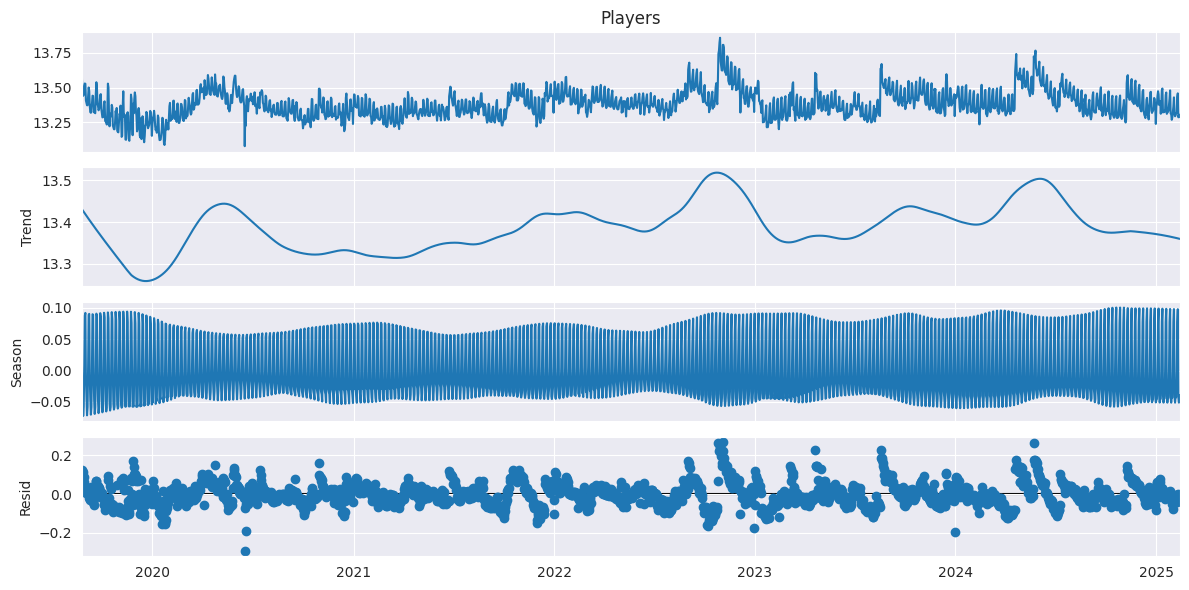

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(np.log(df_players['Players'][-2000:]), period=7, seasonal=7*4+1, trend=183)
res = stl.fit()
res.plot();

По графику декомпозиции видим, что тренд изменяется нелинейно, присутствуют волнообразные движения, возможен мультипликативный характер (но дики фуллер сказал, что в целом ряд стационарен), амплитуда сезонности будто тоже меняется со временем, возможно тоже мультипликативная.


Остатки на нижнем графике разбросаны не симметрично, очень неоднородно, где-то разброс больше, наверное мультипликативная ошибка

## Выбор моделей-кандидатов (0.5 балла)

Исходя из визуального анализа и характеристик ряда, какие вариации ETS-моделей вы бы оценили?

Можно рассматривать все вариации из А и М

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model_aaa = ETSModel(df_players['Players'], error='add', trend='add', seasonal='add').fit()
model_mam = ETSModel(df_players['Players'], error='mul', trend='add', seasonal='mul').fit()
model_maa = ETSModel(df_players['Players'], error='mul', trend='add', seasonal='add').fit()

print(f"AIC ETS(A, A, A): {model_aaa.aic}")
print(f"AIC ETS(M, A, M): {model_mam.aic}")
print(f"AIC ETS(M, A, A): {model_maa.aic}")

AIC ETS(A, A, A): 79019.84351739405
AIC ETS(M, A, M): 78198.411678977
AIC ETS(M, A, A): 78601.64327809612


ETS(M, A, M) (Мультипликативная ошибка, Аддитивный тренд, Мультипликативная сезонность) — лучшая модель по критерию информативности. Эту версию будем реализовывать в классе ниже.

* Величина ошибки зависит от уровня ряда.
* Тренд аддитивный - ряд стационарен
* Сезонность мультипликативная: сезонные колебания пропорциональны уровню ряда

## Кросс-валидация

Мы напишем один большой класс для кросс-валидации со встроенной фильтрацией STL и ETS. Глобально мы хотим на каждом шаге кросс-валидации отфильтровать простые, спрогнозировать их, а для всего что останется построить сложную модель с признаками. На каждом шаге наша логика будет следующей:

1) STL раскладывает ряд на тренд, сезонность и остатки.
    * Спрогнозируем простыми многошаговыми моделями тренд и сезонность.
    * Спрогнозируем остатки сложной моделью со стратегией.
    * Сложим прогнозы, получая итог.

2) ETS согласованно прогнозирует тренд и сезонность.
    * Построим прогноз тренда и сезонности.
    * Возьмём из оценённой модели in-sample остатки, спрогнозируем их отдельной сложной моделью со стратегией
    * Скомбинируем прогноз ETS и прогноз остатков.

    `Внимание!` Если у вас мультипликативные ошибки в ETS-модели, то прогнозы нужно будет не складывать, а умножать в соответствии с формулами ETS-модели.


Заполните класс ниже. Важные комментарии.

1) Обратите внимание на прогнозы in-sample. Это одношаговые прогнозы для каждой точки тренировочного датасета. Мы обсуждали, что большинство моделей обучаются как одношаговые (например, ETS). Следовательно, тестировать автокорреляции также нужно на одношаговых прогнозах. В классе все in_sample прогнозы основаны на одношаговой модели.
2) Для in-sample прогнозов могут быть не определены первые несколько точек. Например, если в модели остатков были лагированные переменные. Исключите из тестов на автокорреляции.
3) Для моделей остатков нужна будет сильная табличная модель с многошаговой стратегией. Используйте любую на своё усмотрение, но прямая будет самой простой. Можете использовать дополнительные переменные из файла или собранные в бонусном пункте.
4) ETS можно брать из statsmodels или statsforecast. В учебных целях statsmodels будет чуть попроще, там немного удобнее реализован доступ к нужным векторам.

## Класс кросс-валидации (4 балла)

In [ ]:
# класс для сложной табличной модели :))
from sklearn.linear_model import LinearRegression

class DirectStrategyLinearModel():
    def __init__(self, horizon: int):
        self.horizon = horizon
        self.models = []

    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        """
        Обучает horizon отдельных моделей линейной регресси
        """
        for step in range(self.horizon):
          model = LinearRegression()
          y_target = y_train.shift(-step).dropna()
          X_target = X_train.iloc[:len(y_target)]
          model.fit(X_target, y_target)
          self.models.append(model)

    def predict(self, X_train: pd.DataFrame) -> np.array:
        """
        Делаем horizon шагов вперед, используя обученные модели
        """
        predictions = []
        X_last = pd.DataFrame(X_train.iloc[-1:])
        for step in range(self.horizon):
            pred = self.models[step].predict(X_last)
            predictions.append(pred[0])
        return np.array(predictions)

    def predict_in_sample(self, X_train: pd.DataFrame):
        """
        Делаем одношаговый прогноз для трейна
        """
        predictions = []
        for i in range(len(X_train)):
            X_row =  pd.DataFrame(X_train.iloc[i:i+1])
            pred = self.models[0].predict(X_row)
            predictions.append(pred[0])

        return np.array(predictions)

In [ ]:
# model = DirectStrategyLinearModel(horizon=14)
# model.fit(X_train, y_train)
# kek = model.predict_in_sample(X_train)

In [ ]:
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

class CrossValDecompose():
    def __init__(
        self,
        window: int,  # Размер окна для обучения
        step_size: int,  # Шаг сдвига окна
        seasonal_period: int,  # Период сезонности
        horizon: int = 14,  # Горизонт прогнозирования
    ):
        self.window = window
        self.horizon = horizon
        self.step_size = step_size
        self.seasonal_period = seasonal_period


    def predict_trend_STL(self, data: pd.Series) -> tuple[pd.Series, pd.Series]:
        # 0.5 балла
        """
        Предсказывает тренд какой-нибудь простой моделью.
        Например экспоненциальным сглаживанием.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """
        model = ExponentialSmoothing(data, trend='add').fit()

        predicted_in_sample = model.fittedvalues
        predicted_out_of_sample = model.forecast(steps = self.horizon)

        assert len(predicted_in_sample) == len(data)
        assert len(predicted_out_of_sample) == self.horizon

        return predicted_in_sample, predicted_out_of_sample


    def predict_seasonality_STL(self,data: pd.Series) -> tuple[pd.Series, pd.Series]:
        # 0.5 балла
        """
        Предсказывает тренд какой-нибудь простой моделью.
        Например, сезонной наивной.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """
        small_array = data[-7:]

        predicted_in_sample = data.shift(self.seasonal_period)
        predicted_in_sample.iloc[:self.seasonal_period] = data.iloc[:self.seasonal_period]
        predicted_out_of_sample = np.tile(small_array, (self.horizon // len(small_array))).flatten()

        assert len(predicted_in_sample) == len(data)
        assert len(predicted_out_of_sample) == self.horizon

        return predicted_in_sample, predicted_out_of_sample


    def predict_error_STL(self, data: pd.Series, features) -> tuple[pd.Series, pd.Series]:
        # 1 балл

        """
        Предсказывает остатки STL сложной табличной моделью.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """
        model = DirectStrategyLinearModel(horizon=self.horizon)
        model.fit(features, data)

        predicted_out_of_sample = model.predict(features)
        predicted_in_sample = model.predict_in_sample(features)

        assert len(predicted_in_sample) == len(data)
        assert len(predicted_out_of_sample) == self.horizon

        return predicted_in_sample, predicted_out_of_sample

    def predict_error_ETS(self, data: pd.Series, features) -> tuple[pd.Series, pd.Series]:
        # 1 балл

        """
        Предсказывает остатки ETS сложной табличной моделью.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """
        model = DirectStrategyLinearModel(horizon=self.horizon)
        model.fit(features, data)

        predicted_out_of_sample = model.predict(features)
        predicted_in_sample = model.predict_in_sample(features)

        assert len(predicted_in_sample) == len(data)
        assert len(predicted_out_of_sample) == self.horizon

        return predicted_in_sample, predicted_out_of_sample


    def predict_STL(self, data: pd.Series, features, seasonal_window = None, trend_window = None) -> tuple[pd.Series, pd.Series]:
        #здесь добавляем seasonal_window и trend_window, будем подбирать гиперпараметры позднее

        # 0.5 балла

        """
        Для одного окна кросс-валидации декомпозирует ряд с помощью STL,
        прогнозирует все компоненты и комбинирует обратно.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """
        stl = STL(data, period=self.seasonal_period, seasonal=seasonal_window, trend=trend_window).fit()

        trend = stl.trend
        seasonality = stl.seasonal
        error = stl.resid

        predicted_t_in_sample, predicted_t_out_of_sample = self.predict_trend_STL(trend)
        predicted_s_in_sample, predicted_s_out_of_sample = self.predict_seasonality_STL(seasonality)
        predicted_e_in_sample, predicted_e_out_of_sample = self.predict_error_STL(error, features)

        predicted_in_sample = predicted_t_in_sample + predicted_s_in_sample + predicted_e_in_sample
        predicted_out_of_sample = predicted_t_out_of_sample + predicted_s_out_of_sample + predicted_e_out_of_sample

        return predicted_in_sample, predicted_out_of_sample

    def predict_ETS(self, data: pd.DataFrame, features) -> tuple[pd.Series, pd.Series]:

        # 0.5 балла
        """
        Для одного окна кросс-валидации декомпозирует ряд с помощью ETS,
        прогнозирует все компоненты и комбинирует обратно.

        predicted_in_sample -- одношаговые прогнозы
        predicted_out_of_sample -- многошаговые прогнозы
        """

        # Оценить ETS и спрогнозировать
        # ets_model = ETSModel(np.array(data).squeeze(), seasonal_periods=self.seasonal_period).fit()
        ets_model = ETSModel(np.array(data).squeeze(), error='mul', trend='add', seasonal='mul', seasonal_periods=self.seasonal_period).fit()

        predicted_t_s_in_sample = ets_model.fittedvalues
        predicted_t_s_out_of_sample = ets_model.forecast(steps=self.horizon)

        error = data / ets_model.fittedvalues.reshape(-1,1)
        predicted_e_in_sample, predicted_e_out_of_sample = self.predict_error_ETS(error, features)

        # Скомбинировать прогнозы
        predicted_in_sample = predicted_t_s_in_sample.reshape(-1,1) * predicted_e_in_sample
        predicted_out_of_sample = predicted_t_s_out_of_sample * predicted_e_out_of_sample.flatten()

        return predicted_in_sample, predicted_out_of_sample

    def cv(self, data: pd.DataFrame, features: pd.DataFrame):
        train_end = len(data)
        while train_end - self.window - self.horizon >= 0:
            train_data = data.iloc[train_end - self.window - self.horizon:train_end - self.horizon]
            val_data = data.iloc[train_end - self.horizon:train_end]

            train_features = features.iloc[train_end - self.window - self.horizon:train_end - self.horizon]

            yield train_data, val_data, train_features

            train_end -= self.step_size


## Выбор моделей (1 балл)
Используйте класс выше. Отберите по кросс-валидации наилучшую STL и наилучшую ETS модели. Метрика -- MAPE.


Сначала подбираем гиперпараметры сглаживания для STL

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [152]:
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm


seasonal_values = [7, 15, 21, 35]
trend_values = [21, 35, 51, 91]

best_params = None
best_mape = float("inf")

for seasonal in tqdm(seasonal_values, desc="Подбор seasonal и trend"):
    for trend in trend_values:
        model = CrossValDecompose(window=50, step_size=35, seasonal_period=7, horizon=14)

        mapes = []
        for train, val, train_features in model.cv(y_train, X_train):
            _,predicted_out_of_sample = model.predict_STL(train, train_features, seasonal_window=seasonal, trend_window=trend)
            mape = mean_absolute_percentage_error(val, predicted_out_of_sample)
            mapes.append(mape)

        avg_mape = np.mean(mapes)
        print(f"STL: seasonal={seasonal}, trend={trend}, MAPE={avg_mape:.6f}")

        if avg_mape < best_mape:
            best_mape = avg_mape
            best_params = (seasonal, trend)
print(f"\nЛучшие параметры: seasonal={best_params[0]}, trend={best_params[1]}, MAPE={best_mape:.6f}")

Подбор seasonal и trend:   0%|          | 0/4 [00:00<?, ?it/s]

STL: seasonal=7, trend=21, MAPE=0.073488
STL: seasonal=7, trend=35, MAPE=0.071009
STL: seasonal=7, trend=51, MAPE=0.070715
STL: seasonal=7, trend=91, MAPE=0.072532


Подбор seasonal и trend:  25%|██▌       | 1/4 [01:09<03:27, 69.10s/it]

STL: seasonal=7, trend=121, MAPE=0.073168
STL: seasonal=15, trend=21, MAPE=0.072039
STL: seasonal=15, trend=35, MAPE=0.070221
STL: seasonal=15, trend=51, MAPE=0.070546
STL: seasonal=15, trend=91, MAPE=0.072664


Подбор seasonal и trend:  50%|█████     | 2/4 [02:11<02:10, 65.11s/it]

STL: seasonal=15, trend=121, MAPE=0.073321
STL: seasonal=21, trend=21, MAPE=0.071798
STL: seasonal=21, trend=35, MAPE=0.070128
STL: seasonal=21, trend=51, MAPE=0.070550
STL: seasonal=21, trend=91, MAPE=0.072686


Подбор seasonal и trend:  75%|███████▌  | 3/4 [03:15<01:04, 64.66s/it]

STL: seasonal=21, trend=121, MAPE=0.073352
STL: seasonal=35, trend=21, MAPE=0.071669
STL: seasonal=35, trend=35, MAPE=0.070098
STL: seasonal=35, trend=51, MAPE=0.070563
STL: seasonal=35, trend=91, MAPE=0.072711


Подбор seasonal и trend: 100%|██████████| 4/4 [04:26<00:00, 66.61s/it]

STL: seasonal=35, trend=121, MAPE=0.073377

Лучшие параметры: seasonal=35, trend=35, MAPE=0.070098


ETS

In [ ]:
# def eval_model(model, data, features, method = 'STL'):
#   mapes = []
#   for train, val, train_features in model.cv(data, features):
#     if method == 'STL':
#       _, predicted_out_of_sample = model.predict_STL(train, train_features)
#     else:
#       _, predicted_out_of_sample = model.predict_ETS(train, train_features)
#     mape = mean_absolute_percentage_error(val, predicted_out_of_sample)
#     mapes.append(mape)
#   return np.mean(mapes)

In [ ]:
# """
#   ищем окно и шаг для св етс
# """

# from tqdm import tqdm
# window_values = [20, 35, 50]
# step_values = [25, 35, 45]
# best_ets_mape = float("inf")

# ets_results = []

# for i in tqdm(window_values):
#   for j in step_values:
#     model = CrossValDecompose(window=i, step_size=j, seasonal_period=7, horizon=14)
#     mape_ets = eval_model(model, data = y_train, features = X_train, method = 'ETS')
#     ets_results.append((i,j, mape_ets))

#     if mape_stl < best_ets_mape:
#       best_ets_mape = mape_ets
#       best_params_ets = (i, j)

## Проверка валидности моделей (1 балл)

1) Обучите две лучшие модели на всём трейне.
2) Постройте прогнозы in-sample на трейн. Вычислите финальные остатки модели как разницу факта и прогноза.
3) Нарисуйте коррелограммы остатков обеих моделей. Есть ли значимые пики?
4) Проведите тесты Ljung-Box для остатков обеих моделей и проинтерпретируйте результат. Данные достаточно простые, постарайтесь чтобы гипотеза не отвергалась.

window=50, step_size=35 я подобрала с помощью функции eval_model (она закоментирована выше)

In [ ]:
seasonal_window, trend_window = best_params
model_stl = CrossValDecompose(window=50, step_size=35, seasonal_period=7, horizon=14)
stl_in_sample = model.predict_STL(y_train, X_train, seasonal_window=seasonal_window, trend_window=trend_window)[0]
stl_in_sample_resid = np.array(stl_in_sample) - np.array(y_train).flatten()

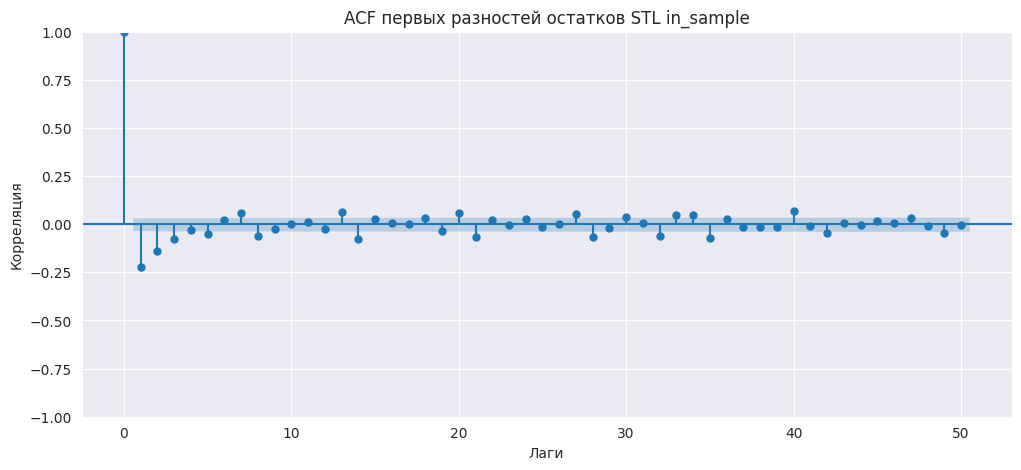

In [151]:
stl_in_sample_resid_diff = pd.DataFrame(stl_in_sample_resid).diff().dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(stl_in_sample_resid_diff, ax=ax, lags=50)

ax.set_title('ACF первых разностей остатков STL in_sample')
ax.set_xlabel('Лаги')
ax.set_ylabel('Корреляция')
ax.grid(True)

Для предсказания ошибок использовалась обычная линейная регрессия, ошибки мультипликативные. Недельная сезонность стала менее выраженной, но все равно присутствует. Возможно, надо было брать бустинг, сейчас еще все закономерности в данных не учтены, остатки не похожи на белый шум(((
  


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(stl_in_sample_resid_diff, lags=[10, 20, 30, 40, 50], return_df=True,boxpierce=True)
print(ljung_box_results)

       lb_stat     lb_pvalue     bp_stat     bp_pvalue
10  288.788172  3.635343e-56  288.426841  4.333590e-56
20  347.845250  1.238054e-61  347.171772  1.703938e-61
30  397.127227  1.063365e-65  396.044488  1.759080e-65
40  463.943105  1.416228e-73  462.106351  3.291537e-73
50  483.968684  2.348925e-72  481.843826  6.118175e-72


Больно. Тест Бокса подтверждает, что автокорреляция есть, даже для самого первого лага.

In [ ]:
model = CrossValDecompose(window=50, step_size=35, seasonal_period=7, horizon=14)
ets_in_sample = model.predict_ETS(y_train, X_train)[0]
ets_in_sample_resid = np.array(y_train) - np.array(ets_in_sample)

Посмотрим, как поживает етс модель

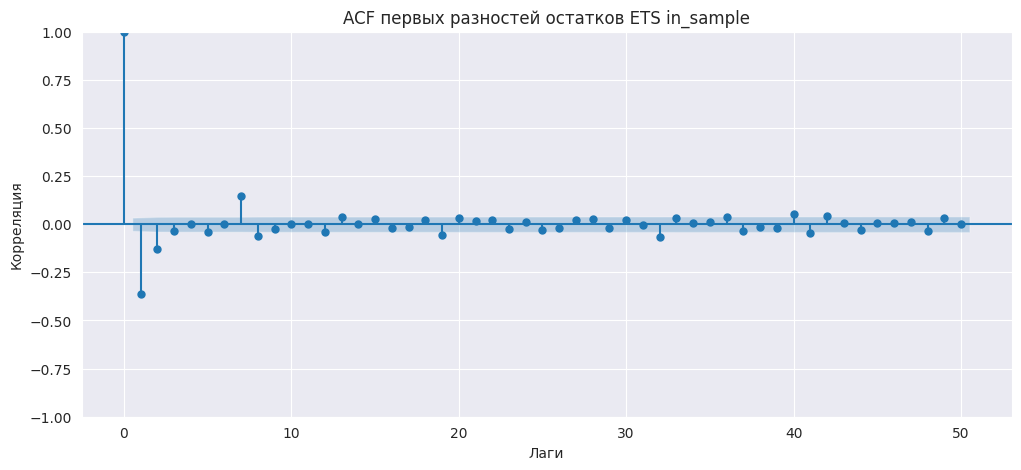

In [155]:
ets_in_sample_resid_diff = pd.DataFrame(ets_in_sample_resid).diff().dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(ets_in_sample_resid_diff, ax=ax, lags=50)

ax.set_title('ACF первых разностей остатков ETS in_sample')
ax.set_xlabel('Лаги')
ax.set_ylabel('Корреляция')
ax.grid(True)

In [156]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(ets_in_sample_resid_diff, lags=[10, 20, 30, 40, 50], return_df=True,boxpierce=True)
print(ljung_box_results)

       lb_stat      lb_pvalue     bp_stat      bp_pvalue
10  588.894531  4.216151e-120  588.173664  6.016304e-120
20  618.468016  3.689633e-118  617.582859  5.670391e-118
30  634.248343  2.349999e-114  633.230917  3.821817e-114
40  673.741562  4.578457e-116  672.279694  9.126251e-116
50  698.855880  3.342384e-115  697.044489  7.770099e-115


Здесь все еще хуже

## Прогнозирование (1 балл)

1) Постройте прогнозы обеих моделей на тестовый период
2) Сравните качество моделей
3) Проведите тест Диболда-Мариано и проведите результаты. Если тест говорит в пользу одной из моделей, то как вы думаете, почему она оказалась лучше?

Прогноз на тесте стл

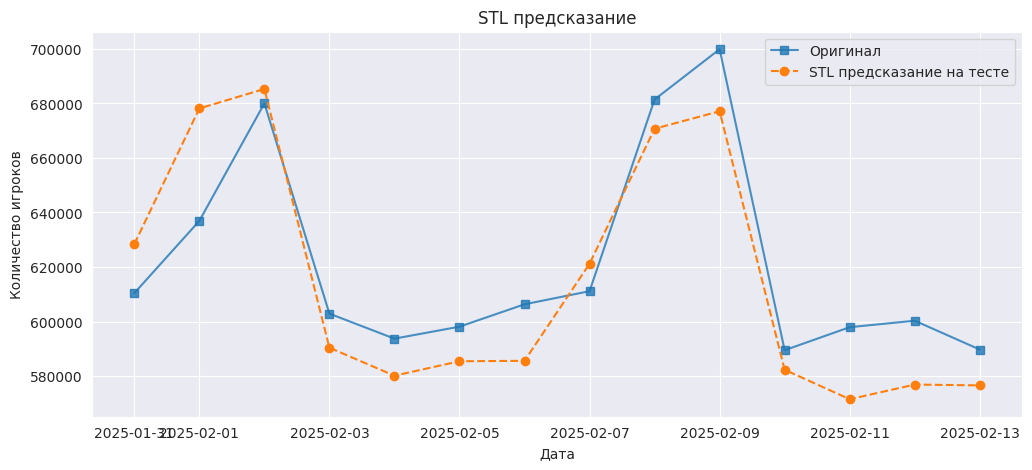

In [157]:
model = CrossValDecompose(window=14, step_size=1, seasonal_period=7, horizon=14)
stl_test_preds = model.predict_STL(y_train, X_train, seasonal_window=seasonal_window, trend_window=trend_window)[1]

plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Оригинал", linestyle="-", marker="s", alpha=0.8)
plt.plot(stl_test_preds,label="STL предсказание на тесте", linestyle="dashed", marker="o")

plt.title("STL предсказание")
plt.xlabel("Дата")
plt.ylabel("Количество игроков")
plt.legend()
plt.grid(True)

In [158]:
mean_absolute_percentage_error(y_test, stl_test_preds)

0.027383235903697158

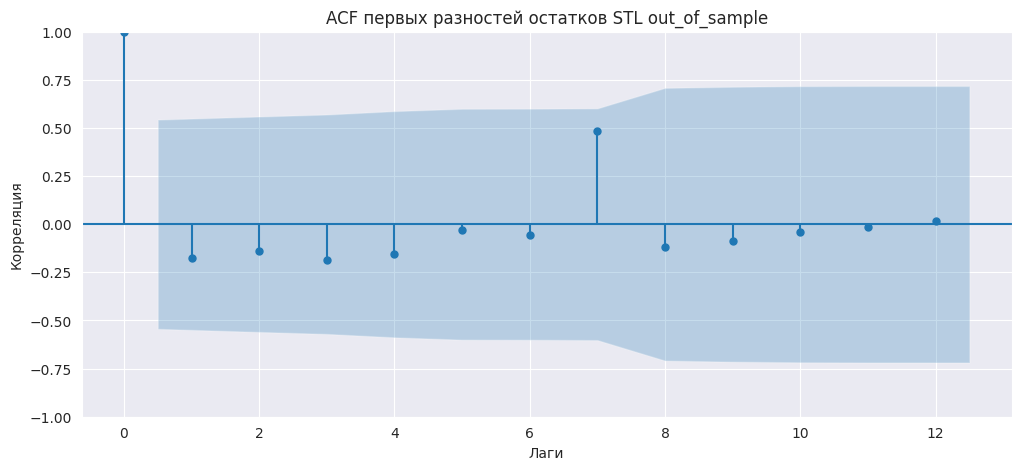

In [ ]:
stl_out_of_sample_resid_diff = pd.DataFrame(stl_test_preds).diff().dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(stl_out_of_sample_resid_diff, ax=ax, lags = 12)

ax.set_title('ACF первых разностей остатков STL out_of_sample')
ax.set_xlabel('Лаги')
ax.set_ylabel('Корреляция')
ax.grid(True)

 Тут автокорреляция незначима

Прогноз на тесте етс

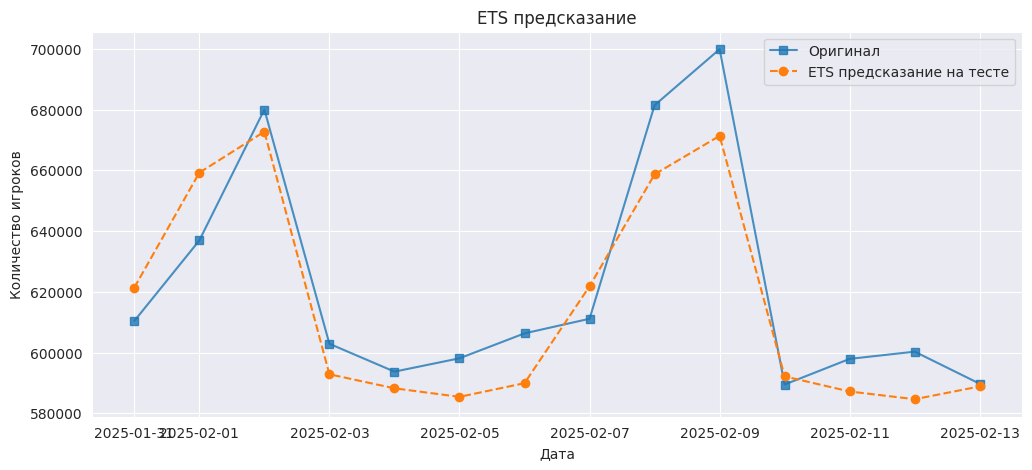

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Оригинал", linestyle="-", marker="s", alpha=0.8)
ets_test_preds = pd.DataFrame(model.predict_ETS(y_train, X_train)[1], index = y_test.index)
plt.plot(ets_test_preds,label="ETS предсказание на тесте", linestyle="dashed", marker="o")

plt.title("ETS предсказание")
plt.xlabel("Дата")
plt.ylabel("Количество игроков")
plt.legend()
plt.grid(True)

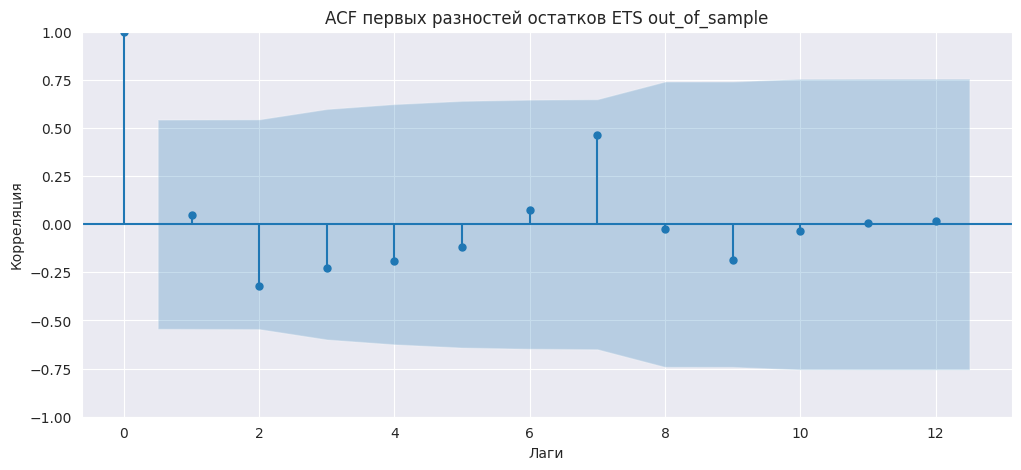

In [ ]:
stl_out_of_sample_resid_diff = pd.DataFrame(ets_test_preds).diff().dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(stl_out_of_sample_resid_diff, ax=ax, lags = 12)

ax.set_title('ACF первых разностей остатков ETS out_of_sample')
ax.set_xlabel('Лаги')
ax.set_ylabel('Корреляция')
ax.grid(True)

Тут тоже автокорреляция незначима

In [ ]:
mean_absolute_percentage_error(y_test, ets_test_preds)

0.01997184051486589

In [ ]:
#from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

errors_model_1 = np.abs(np.array(y_test)-np.array(ets_test_preds)).flatten()  # Абсолютные ошибки для модели ETS
errors_model_2 =  np.abs(np.array(y_test).flatten()-np.array(stl_test_preds)) # Абсолютные ошибки для модели STL

def dm_test(errors_model_1, errors_model_2):
    """
    Diebold-Mariano test for comparing forecast accuracy of two models.

    :param errors_model_1: Forecast errors for model 1 (1D array)
    :param errors_model_2: Forecast errors for model 2 (1D array)
    :return: DM test statistic and p-value
    """
    # Разница квадратов ошибок
    d = (errors_model_1 ** 2) - (errors_model_2 ** 2)

    # Рассчитываем статистику и p-значение для каждого шага
    d_stats = DescrStatsW(d)

    # Статистика теста DM
    dm_stat = np.nanmean(d) / d_stats.std

    # p-значение
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value
# Проведение теста Diebold-Mariano
dm_stat, p_value = dm_test(errors_model_1, errors_model_2)

# Результаты
print(f"DM test statistic: {dm_stat}")
print(f"P-value: {p_value}")

DM test statistic: -0.34324753486030785
P-value: 0.7314122467963735


Тест выше провели совместно с ллмкой.

P-значение в 0.731 указывает на то, что нет статистически значимой разницы между точностью прогнозов двух моделей, можем устверждать, что STL и ETS дают работают примерно одинаково. Одинаково плохо, в моем случае...

##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

P.S. Ваш семинарист хотел бы слетать в космос.

Если бы еще и времени неприлично много было, то я бы хотела выучить все классные скиллы в мире: попасть в топ кулинарную школе во франции, пожить и получиться в шаолиньском монастыре, водить гоночный болид, кататься на сноуборде и тд и тп

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7